In [87]:
import pandas as pd #加载pandas包
import numpy as np #加载numpy包
import matplotlib.pyplot as plt #加载matplot包
from sklearn.model_selection import train_test_split, GridSearchCV #加载sklearn包
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import tensorflow as tf #加载tensorflow包以深度学习
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping #早停
import warnings#取消警告
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import plotly.graph_objects as go#可视化

class HotelData: #构造酒店类
    def __init__(self, file_path):
        self.file_path = file_path #初始化文件路径
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None #初始化训练集预测集
        self.rf_accuracy = None
        self.nn_accuracy = None
        self.rf_model = None
        self.nn_model = None
        self.rf_fpr = None
        self.rf_tpr = None
        self.nn_fpr = None
        self.nn_tpr = None  #初始化预测准确率

    # 1. 上传数据集
    def load_data(self):
        try:
            self.data = pd.read_csv(self.file_path)
            print("Data loaded successfully.")
            print(self.data.head())
        except Exception as e: #如果数据没有成功上传则抛出错误
            print(f"Error loading data: {e}")

    # 2. 简易的数据清洗，处理缺失值
    def handle_missing_values(self):
        print("Missing values before handling:\n", self.data.isnull().sum())
        self.data.fillna(self.data.median(), inplace=True)
        print("Missing values handled.")

    # 3. 添加新的酒店数据
    def add_new_data(self, **new_data): 
        #接收新的酒店预订记录。提供已知的信息即可，对于未提供的信息使用NA填充。但是不可以出现原数据集中没有的字段，否则抛出错误
        try:
            missing_columns = [col for col in self.data.columns if col not in new_data] 
            if missing_columns:
                print(f"Missing values for fields: {missing_columns}. These will be filled with NA.") #提示缺少的信息使用NA填充
            
            complete_data = {col: new_data.get(col, np.nan) for col in self.data.columns}#将新加入的信息汇总到原数据集当中
            new_data_df = pd.DataFrame([complete_data])
            self.data = pd.concat([self.data, new_data_df], ignore_index=True)
            print("New data added successfully.") #提示新预订记录成功添加
            print(new_data_df)
        except Exception as e: #抛出错误：不合规范的格式或者出现了未出现过的字段
            print(f"Error adding new data: {e}")
            
    
    # 4.研究字段信息
    def field_statistics(self, field_name):
        try:
            if field_name not in self.data.columns: #如果输入不是数据集中的字段，则抛出错误
                raise ValueError(f"Field '{field_name}' does not exist in the dataset.")

            # 如果是数值型的字段，则输出该字段的描述统计信息，包括最大值，最小值，平均数，众数，分位数，峰度偏度
            #存储在字典中
            if np.issubdtype(self.data[field_name].dtype, np.number):
                stats = {
                    'mean': self.data[field_name].mean(),
                    'max': self.data[field_name].max(),
                    'min': self.data[field_name].min(),
                    'mode': self.data[field_name].mode()[0],
                    '25th_percentile': self.data[field_name].quantile(0.25),
                    'median': self.data[field_name].median(),
                    '75th_percentile': self.data[field_name].quantile(0.75),
                    'kurtosis': self.data[field_name].kurtosis(),
                    'skewness': self.data[field_name].skew()
                }
                print(f"Statistics for numeric field '{field_name}': {stats}")
                return stats

            #如果是非数值型的字段，则当做因子型统计不同字符的出现次数。
            else:
                value_counts = self.data[field_name].value_counts()
                print(f"Value counts for non-numeric field '{field_name}':\n{value_counts}")
                return value_counts

        except Exception as e:
            print(f"Error calculating statistics for field '{field_name}': {e}") #若不是字段，抛出错误

    # 5.简易数据可视化
    def visualize_data(self, field_name):
        try:
            if field_name not in self.data.columns: #如果输入的参数不是字段名称，则报错
                raise ValueError(f"Field '{field_name}' does not exist in the dataset.")

            if np.issubdtype(self.data[field_name].dtype, np.number): #如果是数值型变量，则绘制直方图。
                plt.hist(self.data[field_name].dropna(), bins=30, edgecolor='k', alpha=0.7)
                plt.title(f"Histogram of {field_name}")
                plt.xlabel(field_name)
                plt.ylabel("Frequency")
                plt.show()
            else: #如果是非数值型变量，则绘制条形图。
                self.data[field_name].value_counts().plot(kind='bar', color='skyblue', edgecolor='k')
                plt.title(f"Bar Chart of {field_name}")
                plt.xlabel(field_name)
                plt.ylabel("Frequency")
                plt.show()
        except Exception as e: #不是字段名称，则报错
            print(f"Error visualizing data for field '{field_name}': {e}")

    # 6. 数据划分，为机器学习模型的训练做准备
    def prepare_data(self):
        print("Preparing data for machine learning...") #提示划分数据中
        df = self.data.copy() #将数据集进行复制
        df = pd.get_dummies(df, drop_first=True)  #onehot编码
        df.fillna(0, inplace=True) 
        self.X = df.drop('is_canceled', axis=1) #按照取消率标签分类
        self.y = df['is_canceled']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        #设置好随机状态随机划分训练集与测试机。80%作为训练集，20%作为测试机。
        print("Data prepared successfully.") #提示数据划分完成

     # 7. 随机森林方法
    def random_forest_study(self, n_estimators=100, max_depth=None, min_samples_split=2):
        print("Training Random Forest...")
        try:
            # 初始化随机森林模型
            self.rf_model = RandomForestClassifier(n_estimators=n_estimators, 
                                                   max_depth=max_depth, 
                                                   min_samples_split=min_samples_split, 
                                                   random_state=42)
            # 训练模型
            self.rf_model.fit(self.X_train, self.y_train)

            # 在测试集上预测
            rf_pred = self.rf_model.predict(self.X_test)
            self.rf_accuracy = accuracy_score(self.y_test, rf_pred)
            print("Random Forest Accuracy:", self.rf_accuracy)
            print(classification_report(self.y_test, rf_pred))

            # 计算 ROC 曲线
            rf_probs = self.rf_model.predict_proba(self.X_test)[:, 1]
            self.rf_fpr, self.rf_tpr, _ = roc_curve(self.y_test, rf_probs)
        
            # 输出特征重要性
            importances = self.rf_model.feature_importances_
            feature_names = self.X_train.columns
            important_features = sorted(zip(importances, feature_names), reverse=True)
            print("Top 10 important features:")
            print(important_features[:10])
        
            return self.rf_accuracy
        except ValueError as e:
            print(f"Error during Random Forest training: {e}")
            print("Check if there are invalid values in the dataset.")


    # 8. 神经网络方法
    def mlp_study(self, epochs=20, dropout_rate=0.2, learning_rate=0.0003, patience=5): #神经网络的参数默认值
        print("Training Neural Network...") #提示神经网络模型训练中
        self.nn_model = Sequential([ #构造神经网络模型层次
            Dense(128, activation='relu', input_shape=(self.X_train.shape[1],)), #使用relu激活函数
            Dropout(dropout_rate), #dropuout百分之二十的神经元，预防过拟合发生
            Dense(64, activation='relu'), #使用relu激活函数全连接
            Dense(1, activation='sigmoid') #使用sigmoid激活函数进行最后的预测
        ])
        optimizer = Adam(learning_rate=learning_rate) #优化器使用adam
        self.nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #对于分类问题采用交叉熵损失函数

        early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True) #早停机制
        history = self.nn_model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])
        #对于过去历史训练的追溯
        nn_loss, self.nn_accuracy = self.nn_model.evaluate(self.X_test, self.y_test)
        print("Neural Network Accuracy:", self.nn_accuracy) #打印神经网络的预测准确率

        # 绘制ROC曲线
        nn_probs = self.nn_model.predict(self.X_test).ravel()
        self.nn_fpr, self.nn_tpr, _ = roc_curve(self.y_test, nn_probs)

        # 绘制训练集和测试机准确率随epoch的变化
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Neural Network Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        return self.nn_accuracy
    
    # 7. 比较两种方法 
    # 另一种训练方式，输入为接受两个参数字典，先后训练两个模型。
    def compare_methods(self, rf_params={}, mlp_params={}):
        print("Comparing Random Forest and Neural Network...")
        self.rf_accuracy = self.random_forest_study(**rf_params)
        self.nn_accuracy = self.mlp_study(**mlp_params)
        print(f"Random Forest Accuracy: {self.rf_accuracy:.4f}, Neural Network Accuracy: {self.nn_accuracy:.4f}")

    # 9. 总结
    def summarize(self):
        print("Summarizing model performance...") #总结此次机器学习任务

        #绘制直方图展示两个模型准确率
        accuracies = {'Random Forest': self.rf_accuracy, 'Neural Network': self.nn_accuracy}
        plt.bar(accuracies.keys(), accuracies.values(), color=['skyblue', 'orange'])
        plt.title("Accuracy Comparison")
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.show()

        # 绘制两个模型的ROC曲线
        plt.figure(figsize=(10, 6))
        plt.plot(self.rf_fpr, self.rf_tpr, label=f"Random Forest (AUC = {auc(self.rf_fpr, self.rf_tpr):.2f})", color='blue')
        plt.plot(self.nn_fpr, self.nn_tpr, label=f"Neural Network (AUC = {auc(self.nn_fpr, self.nn_tpr):.2f})", color='orange')
        plt.plot([0, 1], [0, 1], 'k--', label="Chance")
        plt.title("ROC Curve Comparison")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid()
        plt.show()

        # 总结哪个模型表现更好
        if self.rf_accuracy > self.nn_accuracy:
            result_message = f"Random Forest performed better with an accuracy of {self.rf_accuracy:.4f} compared to Neural Network's {self.nn_accuracy:.4f}."
        elif self.rf_accuracy < self.nn_accuracy:
            result_message = f"Neural Network performed better with an accuracy of {self.nn_accuracy:.4f} compared to Random Forest's {self.rf_accuracy:.4f}."
        else:
            result_message = f"Both models performed equally well with an accuracy of {self.rf_accuracy:.4f}."

        print(result_message)
        return result_message
    
    #10.对新的预定记录做出退订概率的预测
    def predict_cancellation_probability(self, new_record): #输出要求是一条完整的预订记录，不可以有缺失值。
        try:
            if any(pd.isnull(value) for value in new_record.values()):
                raise ValueError("The input record contains missing values. Please provide complete data.") #有预测值导致抛出错误
            
            if self.rf_model is None:
                raise ValueError("Random Forest model has not been trained. Please run random_forest_study first.")
            if self.nn_model is None:
                raise ValueError("Neural Network model has not been trained. Please run mlp_study first.")


            # 加入数据集中
            record_df = pd.DataFrame([new_record])
            record_df = pd.get_dummies(record_df, drop_first=True)
            missing_cols = set(self.X_train.columns) - set(record_df.columns)
            for col in missing_cols:
                record_df[col] = 0

            record_df = record_df[self.X_train.columns]

            #预测取消率
            rf_prob = self.rf_model.predict_proba(record_df)[:, 1][0]
            nn_prob = self.nn_model.predict(record_df).ravel()[0]

            print(f"Random Forest model predicts cancellation probability: {rf_prob:.4f}")
            print(f"Neural Network model predicts cancellation probability: {nn_prob:.4f}")

        except Exception as e:
            print(f"Error predicting cancellation probability: {e}")

    



In [88]:
# 实例化并运行
hotel_data = HotelData(file_path='C:/Users/Lenovo/hotel_bookings.csv') #导入文件
hotel_data.load_data() #加载数据集
hotel_data.handle_missing_values() #显示缺失值情况

Data loaded successfully.
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  .

In [89]:
hotel_data.data.info() #数据具体信息展示

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119390 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [90]:
hotel_data.data.describe() #数据集各个字段总览

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,76.744392,179.584496,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,105.904658,31.500968,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,179.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,179.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [91]:
#数据清洗

# 删除重复的行
hotel_data.data.drop_duplicates(inplace=True)

#删除包含缺失值的行（如果缺失值较少）
hotel_data.data.dropna(subset=['children', 'country'], inplace=True)

#对于分类数据，填充为众数
hotel_data.data['agent'].fillna(hotel_data.data['agent'].mode()[0], inplace=True)

# 处理异常值， adr取值应该大于0， 房间均价不应太高，设置为1000以下。
hotel_data.data = hotel_data.data[(hotel_data.data['adr'] >= 0) & (hotel_data.data['adr'] <= 1000)]

In [92]:
hotel_data.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86942 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           86942 non-null  object 
 1   is_canceled                     86942 non-null  int64  
 2   lead_time                       86942 non-null  int64  
 3   arrival_date_year               86942 non-null  int64  
 4   arrival_date_month              86942 non-null  object 
 5   arrival_date_week_number        86942 non-null  int64  
 6   arrival_date_day_of_month       86942 non-null  int64  
 7   stays_in_weekend_nights         86942 non-null  int64  
 8   stays_in_week_nights            86942 non-null  int64  
 9   adults                          86942 non-null  int64  
 10  children                        86942 non-null  float64
 11  babies                          86942 non-null  int64  
 12  meal                           

In [93]:
#数据可视化
flow_data = hotel_data.data.groupby(['hotel', 'is_canceled'])['is_canceled'].count().reset_index(name='count')

# 构造源和目标列表
labels = ['Resort Hotel', 'City Hotel', 'Cancelled', 'Not Cancelled']  # 标签：酒店类型和取消情况
sources = [0, 0, 1, 1]  # 源节点：度假酒店和城市酒店
targets = [2, 3, 2, 3]  # 目标节点：取消和未取消
values = [flow_data.loc[(flow_data['hotel'] == 'Resort Hotel') & (flow_data['is_canceled'] == 1), 'count'].values[0],
          flow_data.loc[(flow_data['hotel'] == 'Resort Hotel') & (flow_data['is_canceled'] == 0), 'count'].values[0],
          flow_data.loc[(flow_data['hotel'] == 'City Hotel') & (flow_data['is_canceled'] == 1), 'count'].values[0],
          flow_data.loc[(flow_data['hotel'] == 'City Hotel') & (flow_data['is_canceled'] == 0), 'count'].values[0]]  # 流动量

# 绘制桑基图
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
))

# 设置图表标题
fig.update_layout(title_text="Sankey Diagram: Booking Flow by Hotel Type and Cancellation Status", font_size=10)

# 显示图表
fig.show()

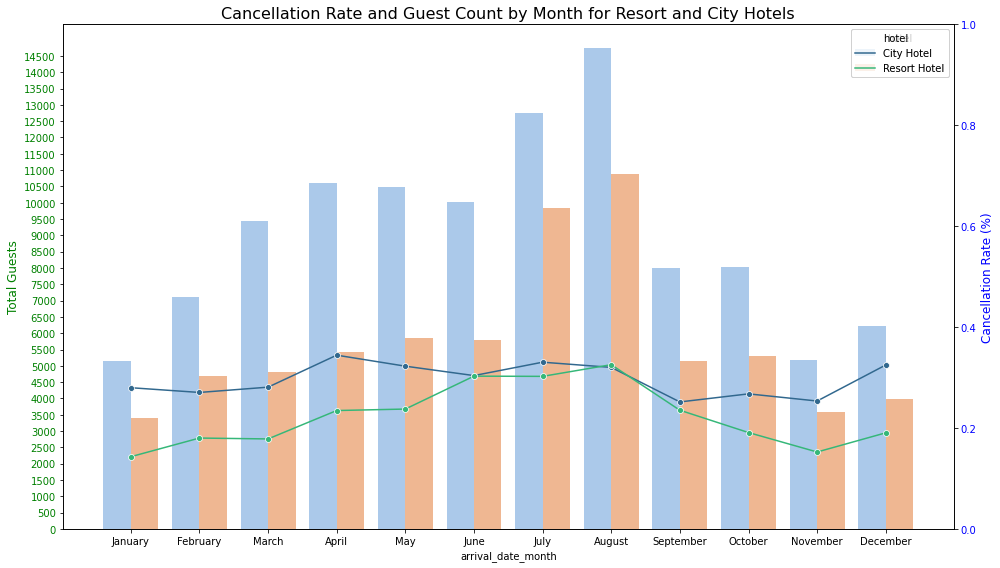

In [94]:
#数据可视化2

# 确保月份按正确的顺序显示
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
hotel_data.data['arrival_date_month'] = pd.Categorical(hotel_data.data['arrival_date_month'], categories=month_order, ordered=True)

# 计算每个月份的取消率
cancel_rate = hotel_data.data.groupby(['arrival_date_month', 'hotel'])['is_canceled'].mean().reset_index()

# 计算每个月份的入住人数
hotel_data.data['total_guests'] = hotel_data.data['adults'] + hotel_data.data['children'] + hotel_data.data['babies']
guests_count = hotel_data.data.groupby(['arrival_date_month', 'hotel'])['total_guests'].sum().reset_index()

# 创建画布
fig, ax1 = plt.subplots(figsize=(14, 8))

sns.barplot(data=guests_count, x='arrival_date_month', y='total_guests', hue='hotel', ax=ax1, palette='pastel', ci=None)
ax1.set_ylabel('Total Guests', fontsize=12, color='green')
ax1.set_yticks(range(0, int(guests_count['total_guests'].max()) + 1, 500))  # 设置入住人数刻度
ax1.tick_params(axis='y', labelcolor='green')

# 创建第二个 Y 轴，用于展示入住人数
ax2 = ax1.twinx()
sns.lineplot(data=cancel_rate, x='arrival_date_month', y='is_canceled', hue='hotel', marker='o', ax=ax2, palette='viridis')
ax2.set_ylabel('Cancellation Rate (%)', fontsize=12, color='blue')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylim(0, 1)  # 设置取消率的范围在 0 到 1 之间
ax2.set_yticks([i * 0.2 for i in range(6)])  # 设置取消率百分比刻度
ax2.tick_params(axis='y', labelcolor='blue')

# 设置标题
plt.title('Cancellation Rate and Guest Count by Month for Resort and City Hotels', fontsize=16)

# 优化布局
plt.tight_layout()

# 显示图表
plt.show()

In [95]:
# 添加新数据示例
hotel_data.add_new_data(hotel="Resort Hotel", is_canceled=0, lead_time=45, adults=2, children=0) #添加含有缺失值的新预订记录
#添加完整的预订记录
new_hotel_data2 = { #新记录字典
    'hotel': 'Resort Hotel',
    'is_canceled': 0,
    'lead_time': 200,
    'arrival_date_year': 2021,
    'arrival_date_month': 'July',
    'arrival_date_week_number': 27,
    'arrival_date_day_of_month': 4,
    'stays_in_weekend_nights': 2,
    'stays_in_week_nights': 5,
    'adults': 2,
    'children': 1,
    'babies': 0,
    'meal': 'BB',
    'country': 'USA',
    'market_segment': 'Direct',
    'distribution_channel': 'Direct',
    'is_repeated_guest': 0,
    'previous_cancellations': 0,
    'previous_bookings_not_canceled': 1,
    'reserved_room_type': 'A',
    'assigned_room_type': 'A',
    'booking_changes': 0,
    'deposit_type': 'No Deposit',
    'agent': 'NULL',
    'company': 'NULL',
    'days_in_waiting_list': 0,
    'customer_type': 'Transient',
    'adr': 100.0,
    'required_car_parking_spaces': 0,
    'total_of_special_requests': 0,
    'reservation_status': 'Check-Out',
    'reservation_status_date': '2021-07-04'
}
hotel_data.add_new_data(**new_hotel_data2) #添加


Missing values for fields: ['arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'total_guests']. These will be filled with NA.
New data added successfully.
          hotel  is_canceled  lead_time  arrival_date_year  \
0  Resort Hotel            0         45                NaN   

   arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                 NaN                       NaN                        NaN   

   stays_in_weekend_nights  stays_in_week_nights  adult

In [96]:
# 计算字段统计信息
hotel_data.field_statistics('lead_time')
hotel_data.field_statistics('adr')
hotel_data.field_statistics('hotel')
hotel_data.field_statistics('test') #检验错误值

Statistics for numeric field 'lead_time': {'mean': 80.18999585940375, 'max': 737, 'min': 0, 'mode': 0, '25th_percentile': 12.0, 'median': 50.0, '75th_percentile': 125.0, 'kurtosis': 2.117116721715409, 'skewness': 1.4283864634460222}
Statistics for numeric field 'adr': {'mean': 106.51160300426159, 'max': 510.0, 'min': 0.0, 'mode': 0.0, '25th_percentile': 72.25, 'median': 98.4, '75th_percentile': 134.1, 'kurtosis': 1.5243967830496663, 'skewness': 0.8647243332220451}
Value counts for non-numeric field 'hotel':
City Hotel      53421
Resort Hotel    33523
Name: hotel, dtype: int64
Error calculating statistics for field 'test': Field 'test' does not exist in the dataset.


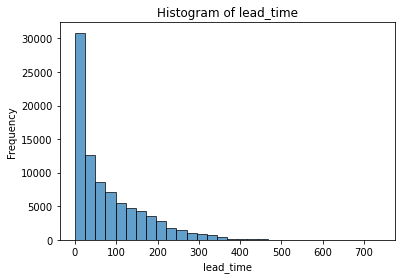

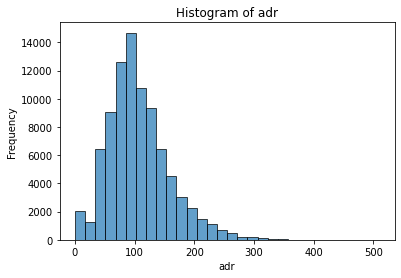

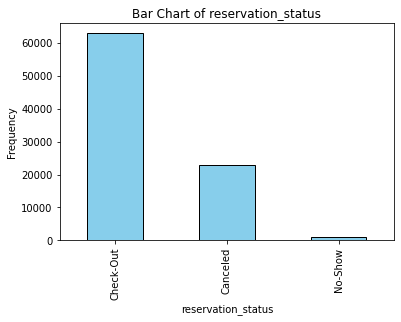

Error visualizing data for field 'test': Field 'test' does not exist in the dataset.


In [97]:
# 数据可视化示例
hotel_data.visualize_data('lead_time')
hotel_data.visualize_data('adr')
hotel_data.visualize_data('reservation_status')
hotel_data.visualize_data('test')#检验错误值

In [98]:
# 数据集划分准备
hotel_data.prepare_data()

Preparing data for machine learning...
Data prepared successfully.


In [99]:
# 随机森林与神经网络的参数控制示例，可以手动进行修改调参
rf_params = {
    'n_estimators':50,  # 决策树的数量
    'max_depth': 20,       # 每棵树的最大深度
    'min_samples_split': 2# 内部节点再划分所需的最小样本数
}

mlp_params = {
    'epochs': 20 ,        # 训练的最大轮次
    'dropout_rate': 0.2 ,
    'learning_rate': 0.001, # 学习率
    'patience': 5          # 提前停止的轮次
}

Training Random Forest...
Random Forest Accuracy: 0.9731439415722584
             precision    recall  f1-score   support

          0       0.96      1.00      0.98     12683
          1       1.00      0.90      0.95      4706

avg / total       0.97      0.97      0.97     17389

Top 10 important features:
[(0.5249039047110129, 'reservation_status_Check-Out'), (0.0337275678678777, 'lead_time'), (0.02651492551488959, 'reservation_status_No-Show'), (0.024344337139977034, 'market_segment_Online TA'), (0.023908769391529413, 'previous_cancellations'), (0.023898519101291548, 'agent_9.0'), (0.02308276370497758, 'country_PRT'), (0.0230308892016456, 'total_of_special_requests'), (0.020134020556996413, 'required_car_parking_spaces'), (0.018790401167700355, 'deposit_type_Non Refund')]
Training Neural Network...
Epoch 1/15
1739/1739 [==============================] - 3s 1ms/step - loss: 0.6103 - accuracy: 0.7873 - val_loss: 0.2232 - val_accuracy: 0.9126
Epoch 2/15
1739/1739 [===================

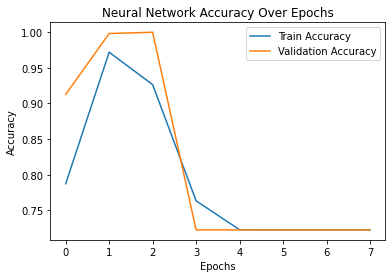

0.9999424815177917

In [100]:
warnings.filterwarnings("ignore")
#按照默认值训练
hotel_data.random_forest_study(n_estimators = 50, max_depth = 20, min_samples_split = 2)
hotel_data.mlp_study(epochs = 15, dropout_rate = 0.2, learning_rate = 0.001, patience = 5) 

Training Neural Network...
Epoch 1/15
1739/1739 [==============================] - 3s 1ms/step - loss: 1.0210 - accuracy: 0.7331 - val_loss: 0.2239 - val_accuracy: 0.9521
Epoch 2/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.1291 - accuracy: 0.9609 - val_loss: 0.0154 - val_accuracy: 0.9996
Epoch 3/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.0202 - accuracy: 0.9968 - val_loss: 0.0123 - val_accuracy: 0.9999
Epoch 4/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.0433 - accuracy: 0.9871 - val_loss: 0.0332 - val_accuracy: 0.9971
Epoch 5/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.0267 - accuracy: 0.9931 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.0544 - accuracy: 0.9838 - val_loss: 0.0575 - val_accuracy: 1.0000
Epoch 7/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.1060 - accuracy: 0.9475 - val_l

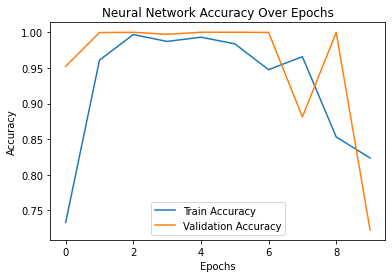

1.0

In [101]:
hotel_data.mlp_study(epochs = 15, dropout_rate = 0.2, learning_rate = 0.0005, patience = 5)

Training Neural Network...
Epoch 1/15
1739/1739 [==============================] - 2s 1ms/step - loss: 2.0654 - accuracy: 0.6411 - val_loss: 0.5181 - val_accuracy: 0.7399
Epoch 2/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.5687 - accuracy: 0.7300 - val_loss: 0.4127 - val_accuracy: 0.8762
Epoch 3/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.3701 - accuracy: 0.8437 - val_loss: 0.2299 - val_accuracy: 0.9544
Epoch 4/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.1852 - accuracy: 0.9426 - val_loss: 0.0906 - val_accuracy: 0.9868
Epoch 5/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.0771 - accuracy: 0.9846 - val_loss: 0.0287 - val_accuracy: 0.9977
Epoch 6/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.0277 - accuracy: 0.9970 - val_loss: 0.0082 - val_accuracy: 0.9998
Epoch 7/15
1739/1739 [==============================] - 2s 1ms/step - loss: 0.0111 - accuracy: 0.9988 - val_l

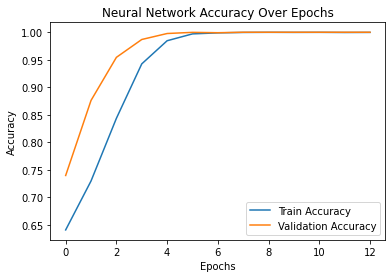

1.0

In [102]:
hotel_data.mlp_study(epochs = 15, dropout_rate = 0.2, learning_rate = 0.0001, patience = 5) #测试

In [103]:
warnings.filterwarnings("ignore")
hotel_data.random_forest_study(n_estimators = 75, max_depth = 25, min_samples_split = 2) #调整参数再次尝试

Training Random Forest...
Random Forest Accuracy: 0.9933291161078843
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     12683
          1       1.00      0.98      0.99      4706

avg / total       0.99      0.99      0.99     17389

Top 10 important features:
[(0.5418683873997372, 'reservation_status_Check-Out'), (0.03608339671087697, 'lead_time'), (0.02960677591122644, 'total_of_special_requests'), (0.025552863482286206, 'market_segment_Online TA'), (0.022635994479471996, 'country_PRT'), (0.021711077391170466, 'required_car_parking_spaces'), (0.021662391219258025, 'agent_9.0'), (0.021401757433690174, 'reservation_status_No-Show'), (0.015313631027682628, 'previous_cancellations'), (0.014198086060593942, 'deposit_type_Non Refund')]


0.9933291161078843

In [104]:
warnings.filterwarnings("ignore")
hotel_data.random_forest_study(n_estimators = 100, max_depth = 50, min_samples_split = 2) #更大的参数

Training Random Forest...
Random Forest Accuracy: 0.9998274771407212
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     12683
          1       1.00      1.00      1.00      4706

avg / total       1.00      1.00      1.00     17389

Top 10 important features:
[(0.5503673445503625, 'reservation_status_Check-Out'), (0.03639135989545775, 'lead_time'), (0.02532809191706752, 'country_PRT'), (0.025312703212939245, 'total_of_special_requests'), (0.016019644514455176, 'required_car_parking_spaces'), (0.015669343902665504, 'agent_9.0'), (0.015497073053797708, 'market_segment_Online TA'), (0.01537378730305531, 'adr'), (0.014103499578373306, 'reservation_status_No-Show'), (0.010616089426613356, 'stays_in_week_nights')]


0.9998274771407212

Comparing Random Forest and Neural Network...
Training Random Forest...
Random Forest Accuracy: 0.9924085576259489
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     12637
          1       1.00      0.97      0.99      4751

avg / total       0.99      0.99      0.99     17388

Training Neural Network...
Epoch 1/20
1739/1739 [==============================] - 2s 1ms/step - loss: 0.8144 - accuracy: 0.7691 - val_loss: 0.1733 - val_accuracy: 0.9349
Epoch 2/20
1739/1739 [==============================] - 2s 1ms/step - loss: 0.0915 - accuracy: 0.9734 - val_loss: 0.0567 - val_accuracy: 0.9945
Epoch 3/20
1739/1739 [==============================] - 2s 1ms/step - loss: 0.1551 - accuracy: 0.9332 - val_loss: 0.1501 - val_accuracy: 0.9998
Epoch 4/20
1739/1739 [==============================] - 2s 1ms/step - loss: 0.2702 - accuracy: 0.8569 - val_loss: 0.1125 - val_accuracy: 0.9999
Epoch 5/20
1739/1739 [==============================] - 2s 1ms/step

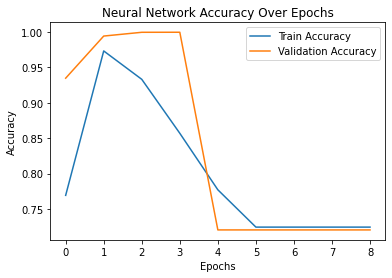

Random Forest Accuracy: 0.9924, Neural Network Accuracy: 0.9996


In [37]:
#另一种方法——使用参数字典的方式训练
warnings.filterwarnings("ignore")
hotel_data.compare_methods(rf_params=rf_params, mlp_params=mlp_params)

Summarizing model performance...


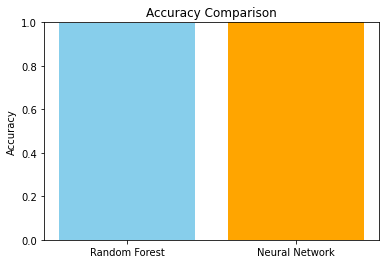

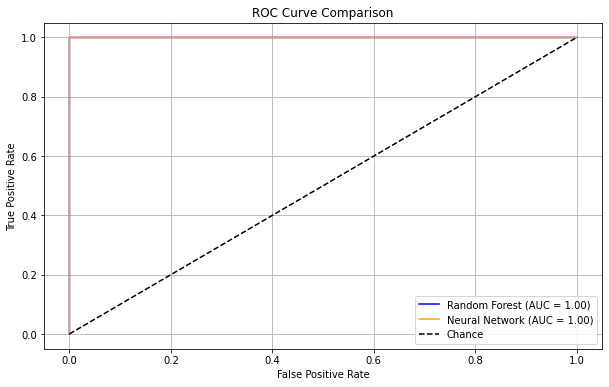

Neural Network performed better with an accuracy of 1.0000 compared to Random Forest's 0.9961.


"Neural Network performed better with an accuracy of 1.0000 compared to Random Forest's 0.9961."

In [64]:
# 总结
hotel_data.summarize()

In [69]:
#构造一条很可能退订的预订信息
high_cancellation_record = {
    'hotel': 'Resort Hotel',
    'is_repeated_guest': 0,          # 非回头客
    'lead_time': 365,               # 提前时间极长
    'arrival_date_year': 2024,
    'arrival_date_month': 'December',
    'arrival_date_week_number': 52,
    'arrival_date_day_of_month': 31,
    'stays_in_weekend_nights': 0,   # 周末天数少
    'stays_in_week_nights': 1,      # 工作日天数少
    'adults': 1,                    # 仅1个成人
    'children': 0,                  # 无儿童
    'babies': 0,                    # 无婴儿
    'meal': 'BB',                   # 早餐计划
    'country': 'PRT',               # 预订来源国家
    'market_segment': 'Online TA',  # 在线旅行社预订
    'distribution_channel': 'TA/TO',
    'is_repeated_guest': 0,
    'previous_cancellations': 3,    # 高取消历史记录
    'previous_bookings_not_canceled': 0,
    'reserved_room_type': 'A',
    'assigned_room_type': 'A',
    'booking_changes': 0,
    'deposit_type': 'Non Refund',   # 非退款政策
    'agent': 1,
    'days_in_waiting_list': 100,    # 较长的等待时间
    'customer_type': 'Transient',
    'adr': 200,                     # 高房价
    'required_car_parking_spaces': 0,
    'total_of_special_requests': 0  # 无特殊需求
}

# 使用训练好的模型预测退订概率
hotel_data.predict_cancellation_probability(high_cancellation_record)

Random Forest model predicts cancellation probability: 0.7003
Neural Network model predicts cancellation probability: 1.0000
